# Classification of basalt source

## Import scientific python libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import copy

from sklearn import neighbors

<img src="./images/volcanic-tectonics.png" width = 800 align = 'center'>

In this assignment you will continue your investigation of igneous geochemistry data. Igneous rocks are those that crystallize from cooling magma. Different magmas have different compositions associated with their origin as we explored a few weeks ago. During class today, we will continue to focus on data from mafic lava flows (these are called basalts and are the relatively low silica, high iron end of what we looked at in week 7).

> Igneous rocks form in a wide variety of tectonic settings,
including mid-ocean ridges, ocean islands, and volcanic
arcs. It is a problem of great interest to igneous petrologists
to recover the original tectonic setting of mafic rocks of the
past. When the geological setting alone cannot unambiguously
resolve this question, the chemical composition of
these rocks might contain the answer. The major, minor,
and trace elemental composition of basalts shows large
variations, for example as a function of formation depth
(e.g., Kushiro and Kuno, 1963) --- *Vermeesch (2006)*

For this analysis we are going to use a dataset that was compiled in 

Vermeesch (2006) Tectonic discrimination of basalts with classification trees, *Geochimica et Cosmochimica Acta*  https://doi.org/10.1016/j.gca.2005.12.016

These data were grouped into 3 categories:

- 256 ***Island arc basalts (IAB)*** from the Aeolian, Izu-Bonin, Kermadec, Kurile, Lesser Antilles, Mariana, Scotia, and Tonga arcs.
- 241 ***Mid-ocean ridge (MORB)*** samples from the East Pacific Rise, Mid Atlantic Ridge, Indian Ocean, and Juan de Fuca Ridge.
- 259 ***Ocean-island (OIB)*** samples from St. Helena, the Canary, Cape Verde, Caroline, Crozet, Hawaii-Emperor, Juan Fernandez, Marquesas, Mascarene, Samoan, and Society islands.

**Let's look at the illustration above and determine where each of these settings are within a plate tectonic context**

## Import data


The data are from the supplemental materials of the Vermeesch (2006) paper. The samples are grouped by affinity MORB, OIB, and IAB. They are additionally assigned affinity codes and colors from the default matplotlib cycle:

|affinity| affinity code | color |
|--------|---------------|-------|
| MORB| 0 | C0
| OIB |  1 | C1
| IAB |  2 | C2

In [2]:
basalt_data = pd.read_csv('./data/Vermeesch2006.csv')

In [3]:
basalt_data.columns

Index(['affinity', 'affinity code', 'color', 'SiO2 (wt%)', 'TiO2 (wt%)',
       'Al2O3 (wt%)', 'Fe2O3 (wt%)', 'FeO (wt%)', 'CaO (wt%)', 'MgO (wt%)',
       'MnO (wt%)', 'K2O (wt%)', 'Na2O (wt%)', 'P2O5(wt%)', 'La (ppm)',
       'Ce (ppm)', 'Pr (ppm)', 'Nd (ppm)', 'Sm (ppm)', 'Eu (ppm)', 'Gd (ppm)',
       'Tb (ppm)', 'Dy (ppm)', 'Ho (ppm)', 'Er (ppm)', 'Tm (ppm)', 'Yb (ppm)',
       'Lu (ppm)', 'Sc (ppm)', 'V (ppm)', 'Cr (ppm)', 'Co (ppm)', 'Ni (ppm)',
       'Cu (ppm)', 'Zn (ppm)', 'Ga (ppm)', 'Rb (ppm)', 'Sr (ppm)', 'Y (ppm)',
       'Zr (ppm)', 'Nb (ppm)', 'Sn (ppm)', 'Cs (ppm)', 'Ba (ppm)', 'Hf (ppm)',
       'Ta (ppm)', 'Pb (ppm)', 'Th (ppm)', 'U (ppm)', '143Nd/144Nd',
       '87Sr/86Sr', '206Pb/204Pb', '207Pb/204Pb', '208Pb/204Pb'],
      dtype='object')

In [4]:
MORB_data = basalt_data[basalt_data['affinity']=='MORB']
OIB_data = basalt_data[basalt_data['affinity']=='OIB']
IAB_data = basalt_data[basalt_data['affinity']=='IAB']

## Can geochemical data be used to classify the tectonic setting?

These data are labeled. The author already determined what setting these basalts came from. However, is there a way that we could use these labeled data to determine the setting for an unknown basalt?

A paper published in 1982 proposed that the elements titanium and vanadium were particular good at giving insight into tectonic setting. The details of why are quite complicated and can be summarized as "the depletion of V relative to Ti is a function of the fO2 of the magma and its source, the degree of partial melting, and subsequent fractional crystallization." If you take EPS100B you will learn more about the fundamentals behind this igneous petrology. *For the moment you can consider the working hypothesis behind this classification to that different magmatic environments have differences in oxidation states that are reflected in Ti vs V ratios.*

Shervais, J.W. (1982) Ti-V plots and the petrogenesis of modern and ophiolitic lavas *Earth and Planetary Science Letters* https://doi.org/10.1016/0012-821X(82)90120-0

### Plot TiO2 (wt%) vs V (ppm)

**Make a scatter plot of TiO2 (wt%) vs V (ppm) with the markers color-coded by affinity. Include axis labels and a legend.**

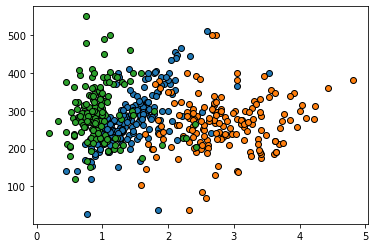

In [5]:
#Note you get keyerror if you type in column name directly, or if you copy from jupyter
#If you copy from the csv file it works???

plt.scatter(MORB_data['TiO2 (wt%)'],MORB_data['V (ppm)'],label='mid-ocean ridge',edgecolors='black')
plt.scatter(OIB_data['TiO2 (wt%)'],OIB_data['V (ppm)'],label='ocean island',edgecolors='black')
plt.scatter(IAB_data['TiO2 (wt%)'],IAB_data['V (ppm)'],label='island arc',edgecolors='black')
plt.show()

## Classification by-eye method

In order to classify the basalt into their affinity based on titanium and vanadium concentrations, we can use a classification method.

The goal here is to be able to make an inference of what environment an unknown basalt formed in based on comparison to these data.

Let's say that we have three points where there affinity is unknown.
- point 1 has TiO2 of 4% and V concentration of 300 ppm
- point 2 has TiO2 of 1% and V concentration of 350 ppm
- point 3 has TiO2 of 1.9% and V concentration of 200 ppm

In [6]:
point_1_TiO2 = 4
point_1_V = 300
point_2_TiO2 = 1
point_2_V = 350
point_3_TiO2 = 1.9
point_3_V = 200

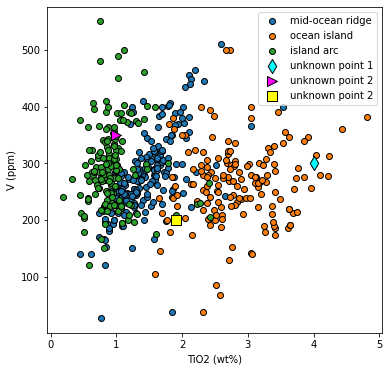

In [7]:
plt.figure(figsize=(6,6))
plt.scatter(MORB_data['TiO2 (wt%)'],MORB_data['V (ppm)'],label='mid-ocean ridge',edgecolors='black')
plt.scatter(OIB_data['TiO2 (wt%)'],OIB_data['V (ppm)'],label='ocean island',edgecolors='black')
plt.scatter(IAB_data['TiO2 (wt%)'],IAB_data['V (ppm)'],label='island arc',edgecolors='black')
plt.scatter(point_1_TiO2,point_1_V,label='unknown point 1',color='cyan',edgecolors='black',marker='d',s=100)
plt.scatter(point_2_TiO2,point_2_V,label='unknown point 2',color='magenta',edgecolors='black',marker='>',s=100)
plt.scatter(point_3_TiO2,point_3_V,label='unknown point 2',color='yellow',edgecolors='black',marker='s',s=100)
plt.xlabel('TiO2 (wt%)')
plt.ylabel('V (ppm)')
plt.legend()
plt.show()

***WRITE HOW YOU THINK THEY SHOULD BE CLASSIFIED HERE***

Point1=OIB, Point2=IAB, Point1=OIB

## Nearest Neighbors Classification

In nearest neighbors classification, classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point. There are different ways this can be done and can be weighted.

### Filter the data to ones that have Ti and V data

**Filter out the rows with NaN values in the `TiO2 (wt%)` or `'V (ppm)'` columns** (i.e. keep rows where its is not true that both of these are nans, you may need `~` and `isna()`).

In [8]:
basalt_data_Ti_V = basalt_data[(~basalt_data['TiO2 (wt%)'].isna()) & (~basalt_data['V (ppm)'].isna())]

### Normalize the data

Given that the nearest neighbor is a distance and TiO2 and V have ranges that are so different (in part because of different units) you need to normalize the data. Divide the 'TiO2 (wt%)' by the maximum 'TiO2 (wt%)' to get a value between 0 and 1. Do the same for V (ppm) as well.

**Add to your filtered dataframe a column called Ti_norm that is normalized TiO2.**

In [9]:
basalt_data_Ti_V['Ti_norm']=basalt_data_Ti_V['TiO2 (wt%)']/np.max(basalt_data_Ti_V['TiO2 (wt%)'])
basalt_data_Ti_V['V_norm']=basalt_data_Ti_V['V (ppm)']/np.max(basalt_data_Ti_V['V (ppm)'])

**Make a column called V_norm that is normalized vanadium.**

**Make a scatter plot of Ti_norm vs V_norm that is colored by affinity.** It should look a lot like the previous scatter plots.

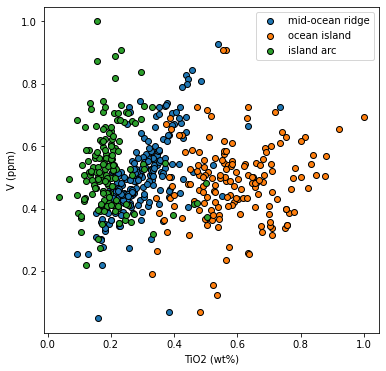

In [10]:
MORB_data = basalt_data_Ti_V[basalt_data_Ti_V['affinity']=='MORB']
OIB_data = basalt_data_Ti_V[basalt_data_Ti_V['affinity']=='OIB']
IAB_data = basalt_data_Ti_V[basalt_data_Ti_V['affinity']=='IAB']

plt.figure(figsize=(6,6))
plt.scatter(MORB_data['Ti_norm'],MORB_data['V_norm'],label='mid-ocean ridge',edgecolors='black')
plt.scatter(OIB_data['Ti_norm'],OIB_data['V_norm'],label='ocean island',edgecolors='black')
plt.scatter(IAB_data['Ti_norm'],IAB_data['V_norm'],label='island arc',edgecolors='black')
plt.xlabel('TiO2 (wt%)')
plt.ylabel('V (ppm)')
plt.legend()
plt.show()


### Preparing arrays of the data

**Make a 2 x n array of the TiO2 (wt%) and V (ppm) values (where n is the number of data points) and a 1 x n array of the classifications (the tectonic affinities).**

In [12]:
basalt_Ti_V = basalt_data_Ti_V[['Ti_norm', 'V_norm']].values
basalt_affinity = basalt_data_Ti_V['affinity'].tolist()
basalt_affinity_code = basalt_data_Ti_V['affinity code'].tolist()

### Define your classifier

**Construct a classifier that uses the 5 nearest neighbors (`n_neighbors=5`) and weight points by the inverse of their distance (`weights='distance'`) such that closer neighbors of a query point will have a greater influence than neighbors which are further away.**

In [13]:
classifier_neighbors = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance')

### Fit/train the classifier

**Feed the array of the data and the array of the classification in a `.fit` function preformed on the classifier object.**

In [14]:
classifier_neighbors.fit(basalt_Ti_V, basalt_affinity)

KNeighborsClassifier(weights='distance')

### Normalize the mystery points

In [15]:
point_1_TiO2_norm = 4/np.max(basalt_data_Ti_V['TiO2 (wt%)'])
point_1_V_norm = 300/np.max(basalt_data_Ti_V['V (ppm)'])
point_2_TiO2_norm = 1/np.max(basalt_data_Ti_V['TiO2 (wt%)'])
point_2_V_norm = 350/np.max(basalt_data_Ti_V['V (ppm)'])
point_3_TiO2_norm = 1.9/np.max(basalt_data_Ti_V['TiO2 (wt%)'])
point_3_V_norm = 200/np.max(basalt_data_Ti_V['V (ppm)'])

### Predict the tectonic affinity of the mystery points using the neighbors classifier

**Use `.predict` to predict the tectonic affinity of these normalized mystery points using the trained neighbors alorithm.**

In [16]:
classifier_neighbors.predict([[point_1_TiO2_norm,point_1_V_norm],
                             [point_2_TiO2_norm,point_2_V_norm],
                             [point_3_TiO2_norm,point_3_V_norm]])

array(['OIB', 'IAB', 'OIB'], dtype='<U4')

### Fit/train using the basalt_affinity_code rather than the string names and use it to predict basalt_affinity_code for the mystery points

In [17]:
classifier_neighbors.fit(basalt_Ti_V, basalt_affinity_code)
classifier_neighbors.predict([[point_1_TiO2_norm,point_1_V_norm],
                             [point_2_TiO2_norm,point_2_V_norm],
                             [point_3_TiO2_norm,point_3_V_norm]])

array([1, 2, 1])

### Visualizing the decision boundary

**Make a 101 x 101 grid of x and y values between 0 and 1.**

In [18]:
xx, yy = np.meshgrid(np.linspace(0, 1, 101),
                     np.linspace(0, 1, 101))
grid = np.c_[xx.ravel(), yy.ravel()]

### Classify the grid

**Use `.predict` to predict the tectonic affinity of these grid points using the trained neighbors alorithm.**

In [19]:
grid_classes=classifier_neighbors.predict(grid)
grid_classes=grid_classes.reshape(xx.shape)

**Plot the classification boundaries by plotting the grid points colorcoded by their classifation. Add a scatter plot of the observed (normalized) data points points colorcoded by their labels on top.**

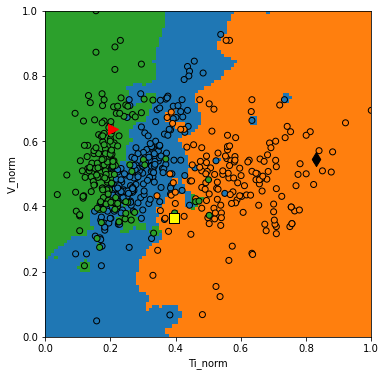

In [20]:
cmap = ListedColormap(['C0', 'C1', 'C2'])

plt.figure(figsize=(6,6))

plt.pcolormesh(xx, yy, grid_classes, cmap=cmap)
scatter_plot = plt.scatter(basalt_data_Ti_V['Ti_norm'],basalt_data_Ti_V['V_norm'],
                           color=basalt_data_Ti_V['color'],edgecolors='black')

plt.scatter(point_1_TiO2_norm,point_1_V_norm,label='unknown point 1',color='black',marker='d',s=100)
plt.scatter(point_2_TiO2_norm,point_2_V_norm,label='unknown point 2',color='red',marker='>',s=100)
plt.scatter(point_3_TiO2_norm,point_3_V_norm,label='unknown point 2',color='yellow',edgecolors='black',marker='s',s=100)

plt.xlabel('Ti_norm')
plt.ylabel('V_norm')
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect('equal', 'box')
plt.show()

## Training and testing

How good is your nearest neighbor classifier? To answer this you'll need to find out how frequently your classifications are correct.


### Making a training and testing data set

There are 514 rows with TiO2 and V data. Use a random half of them for training and the other half for testing. To do this, shuffle all the rows, take the first 257 as the training set, and the remaining 257 for testing.

In [21]:
# Make a randomly ordered dataframe from the initial one
randomized_basalt_data = basalt_data_Ti_V.sample(frac=1) 

# Take the first 257 data points to use for "training"
training_data = copy.deepcopy(randomized_basalt_data.iloc[0:257])

# Use the rest to apply our machine learning on
remaining_data = copy.deepcopy(randomized_basalt_data.iloc[257:])

In [22]:
basalt_Ti_V_training = training_data[['Ti_norm', 'V_norm']].values
basalt_Ti_V_remaining = remaining_data[['Ti_norm', 'V_norm']].values
basalt_affinity_training = training_data['affinity code'].tolist()

In [23]:
classifier_neighbors = neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance')
classifier_neighbors.fit(basalt_Ti_V_training, basalt_affinity_training)

KNeighborsClassifier(n_neighbors=10, weights='distance')

### Visualize the classification regions fit with half the data

Send the grid to the classifier to see the classification regions and decision boundary that has been fit with half of the data.

In [24]:
grid_classes = classifier_neighbors.predict(grid)
grid_classes = grid_classes.reshape(xx.shape)

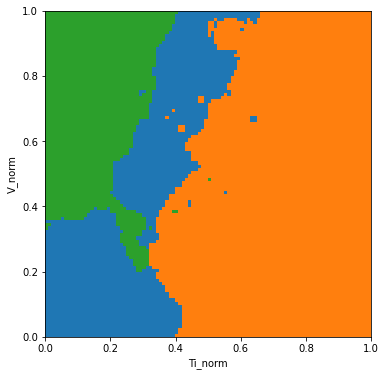

In [25]:
plt.figure(figsize=(6,6))
plt.pcolormesh(xx, yy, grid_classes, cmap=cmap)
plt.xlabel('Ti_norm')
plt.ylabel('V_norm')
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect('equal', 'box')
plt.show()

### Compare the remaining data (test data) to the classification regions

Place the test data on this graph and you can see at once that while the classifier got many of the points right, there are some mis-classified points.

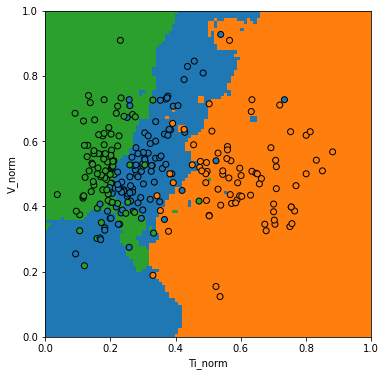

In [26]:
cmap = ListedColormap(['C0', 'C1', 'C2'])
plt.figure(figsize=(6,6))
plt.pcolormesh(xx, yy, grid_classes, cmap=cmap)

plt.scatter(remaining_data['Ti_norm'],remaining_data['V_norm'],
                           color=remaining_data['color'],edgecolors='black')

plt.xlabel('Ti_norm')
plt.ylabel('V_norm')
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect('equal', 'box')
plt.show()

### Estimating the accuracy of the classifier

Since the test set was chosen randomly from the original sample it should preform with similar accuracy on the overall population. Let's calculate the success rate of the classification.

Input the remaining data (test data) to the classifier and then assign these classified affinities to a new column in pandas.

In [27]:
remaining_classes = classifier_neighbors.predict(basalt_Ti_V_remaining)

In [28]:
remaining_data['predicted_class'] = remaining_classes

In [29]:
remaining_data.head()

,affinity,affinity code,color,SiO2 (wt%),TiO2 (wt%),Al2O3 (wt%),Fe2O3 (wt%),FeO (wt%),CaO (wt%),MgO (wt%),MnO (wt%),K2O (wt%),Na2O (wt%),P2O5(wt%),La (ppm),Ce (ppm),Pr (ppm),Nd (ppm),Sm (ppm),Eu (ppm),Gd (ppm),Tb (ppm),Dy (ppm),Ho (ppm),Er (ppm),Tm (ppm),Yb (ppm),Lu (ppm),Sc (ppm),V (ppm),Cr (ppm),Co (ppm),Ni (ppm),Cu (ppm),Zn (ppm),Ga (ppm),Rb (ppm),Sr (ppm),Y (ppm),Zr (ppm),Nb (ppm),Sn (ppm),Cs (ppm),Ba (ppm),Hf (ppm),Ta (ppm),Pb (ppm),Th (ppm),U (ppm),143Nd/144Nd,87Sr/86Sr,206Pb/204Pb,207Pb/204Pb,208Pb/204Pb,Ti_norm,V_norm,predicted_class
182,MORB,0,C0,49.760,2.100,13.77,NaN,NaN,10.82,6.600,0.220,0.120,2.430,0.180,NaN,NaN,NaN,13.23,4.730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,456.0,206.0,45.00,70.00,63.00,112.00,NaN,1.19,100.9,51.00,136.0,4.00,NaN,NaN,NaN,NaN,NaN,0.436,NaN,NaN,0.513208,NaN,NaN,NaN,NaN,0.436590,0.829091,0
558,IAB,2,C2,47.460,1.022,14.86,NaN,NaN,12.62,10.020,0.172,0.791,2.310,0.172,11.32,25.10,NaN,15.57,3.833,1.225,3.88,NaN,3.59,NaN,2.025,NaN,1.82,0.261,37.0,274.0,435.0,NaN,166.00,109.00,68.00,16.00,13.10,586.0,20.70,73.3,6.66,NaN,NaN,216.00,NaN,NaN,2.500,2.900,1.45,0.512918,0.704610,19.179,15.703,38.777,0.212474,0.498182,0
401,OIB,1,C1,45.670,2.420,19.65,NaN,NaN,12.44,3.800,0.150,0.690,2.450,0.230,14.00,35.00,NaN,20.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,393.0,27.0,NaN,27.00,101.00,80.00,NaN,18.00,532.0,23.00,144.0,18.00,NaN,NaN,164.00,NaN,NaN,NaN,5.000,NaN,NaN,NaN,NaN,NaN,NaN,0.503119,0.714545,1
20,MORB,0,C0,50.780,1.050,16.32,0.93,6.92,11.76,8.830,0.160,0.070,2.950,0.130,2.64,9.20,NaN,7.90,2.450,1.000,NaN,0.59,NaN,NaN,NaN,NaN,2.49,0.380,34.0,224.0,382.0,39.10,120.00,75.00,63.00,15.00,1.00,146.0,24.00,79.0,2.20,NaN,NaN,28.00,1.60,NaN,4.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218295,0.407273,2
4,MORB,0,C0,50.325,1.630,15.46,10.71,NaN,10.79,7.655,0.180,0.130,3.125,0.160,4.20,13.19,2.08,11.40,3.610,1.310,4.77,0.89,5.74,1.21,3.500,0.52,3.47,0.540,39.0,301.4,282.6,46.89,116.33,65.85,77.92,15.49,1.45,140.7,36.26,116.6,3.28,NaN,0.022,14.94,2.91,0.202,0.604,0.216,0.07,0.513147,0.702517,18.438,15.487,37.865,0.338877,0.548000,0


Now you have a new column of the classified affinities for the test data. You also have the actually affinities given that the data were originally labeled with classifications. How often do they agree?

In [30]:
remaining_data['correct_assignment'] = remaining_data['predicted_class'].eq(remaining_data['affinity code'])
remaining_data.head()

,affinity,affinity code,color,SiO2 (wt%),TiO2 (wt%),Al2O3 (wt%),Fe2O3 (wt%),FeO (wt%),CaO (wt%),MgO (wt%),MnO (wt%),K2O (wt%),Na2O (wt%),P2O5(wt%),La (ppm),Ce (ppm),Pr (ppm),Nd (ppm),Sm (ppm),Eu (ppm),Gd (ppm),Tb (ppm),Dy (ppm),Ho (ppm),Er (ppm),Tm (ppm),Yb (ppm),Lu (ppm),Sc (ppm),V (ppm),Cr (ppm),Co (ppm),Ni (ppm),Cu (ppm),Zn (ppm),Ga (ppm),Rb (ppm),Sr (ppm),Y (ppm),Zr (ppm),Nb (ppm),Sn (ppm),Cs (ppm),Ba (ppm),Hf (ppm),Ta (ppm),Pb (ppm),Th (ppm),U (ppm),143Nd/144Nd,87Sr/86Sr,206Pb/204Pb,207Pb/204Pb,208Pb/204Pb,Ti_norm,V_norm,predicted_class,correct_assignment
182,MORB,0,C0,49.760,2.100,13.77,NaN,NaN,10.82,6.600,0.220,0.120,2.430,0.180,NaN,NaN,NaN,13.23,4.730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,456.0,206.0,45.00,70.00,63.00,112.00,NaN,1.19,100.9,51.00,136.0,4.00,NaN,NaN,NaN,NaN,NaN,0.436,NaN,NaN,0.513208,NaN,NaN,NaN,NaN,0.436590,0.829091,0,True
558,IAB,2,C2,47.460,1.022,14.86,NaN,NaN,12.62,10.020,0.172,0.791,2.310,0.172,11.32,25.10,NaN,15.57,3.833,1.225,3.88,NaN,3.59,NaN,2.025,NaN,1.82,0.261,37.0,274.0,435.0,NaN,166.00,109.00,68.00,16.00,13.10,586.0,20.70,73.3,6.66,NaN,NaN,216.00,NaN,NaN,2.500,2.900,1.45,0.512918,0.704610,19.179,15.703,38.777,0.212474,0.498182,0,False
401,OIB,1,C1,45.670,2.420,19.65,NaN,NaN,12.44,3.800,0.150,0.690,2.450,0.230,14.00,35.00,NaN,20.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,393.0,27.0,NaN,27.00,101.00,80.00,NaN,18.00,532.0,23.00,144.0,18.00,NaN,NaN,164.00,NaN,NaN,NaN,5.000,NaN,NaN,NaN,NaN,NaN,NaN,0.503119,0.714545,1,True
20,MORB,0,C0,50.780,1.050,16.32,0.93,6.92,11.76,8.830,0.160,0.070,2.950,0.130,2.64,9.20,NaN,7.90,2.450,1.000,NaN,0.59,NaN,NaN,NaN,NaN,2.49,0.380,34.0,224.0,382.0,39.10,120.00,75.00,63.00,15.00,1.00,146.0,24.00,79.0,2.20,NaN,NaN,28.00,1.60,NaN,4.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218295,0.407273,2,False
4,MORB,0,C0,50.325,1.630,15.46,10.71,NaN,10.79,7.655,0.180,0.130,3.125,0.160,4.20,13.19,2.08,11.40,3.610,1.310,4.77,0.89,5.74,1.21,3.500,0.52,3.47,0.540,39.0,301.4,282.6,46.89,116.33,65.85,77.92,15.49,1.45,140.7,36.26,116.6,3.28,NaN,0.022,14.94,2.91,0.202,0.604,0.216,0.07,0.513147,0.702517,18.438,15.487,37.865,0.338877,0.548000,0,True


In [31]:
remaining_data['correct_assignment'].value_counts(normalize=True) * 100

True     84.435798
False    15.564202
Name: correct_assignment, dtype: float64

### Using scikit-learn functions to get an accuracy score of this nearest neighbor approach

Given that this approach of randomly splitting the data into training and test groups is quite common in machine learning classification, there are built-in convenience functions that can be used to more compactly do the same operations that you did above: `train_test_split` and `accuracy_score`.

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(basalt_Ti_V, basalt_affinity_code,train_size=0.5)

# fit the model on one set of data
classifier_neighbors.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = classifier_neighbors.predict(X2)
accuracy_score(y2, y2_model)

0.8482490272373541

## Other classification algorithms

If you go to the scikit-learn homepage you will find many available classifiers: https://scikit-learn.org/stable/index.html. They are nicely illustrated in this code from the scikit-learn documentation.

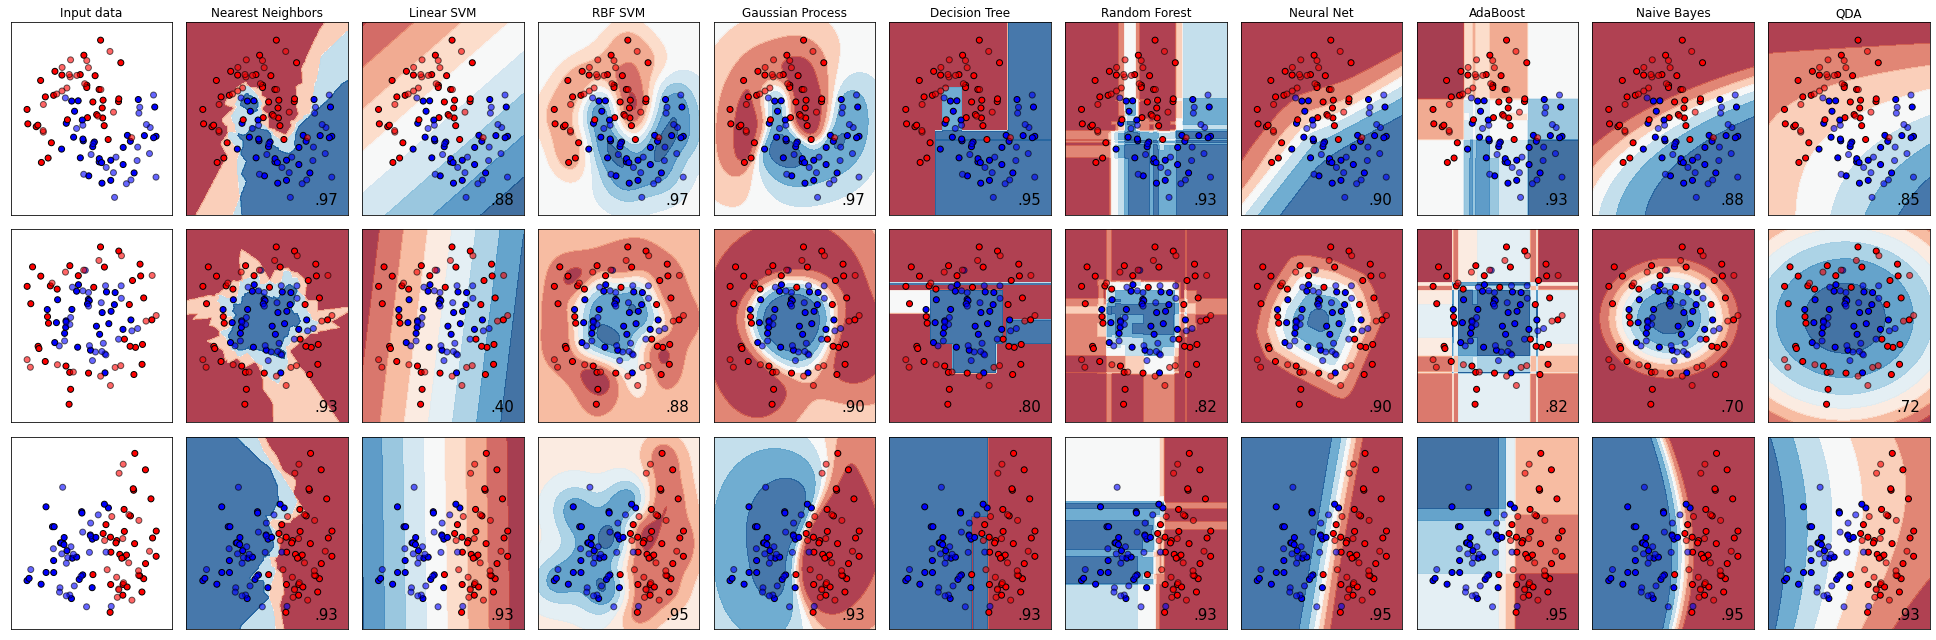

In [34]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

As a word of warning, we shouldn't get too carried away. Clearly, there are complexities related to this approach (our accuracy scores aren't that high). Shervais notes that: 
> "More specific evaluation of the tectonic setting of these and other ophiolites requires
application of detailed geologic and petrologic data as well as geochemistry. The Ti/V discrimination diagram, however,
is a potentially powerful adjunct to these techniques."

Additionally, we would like to be able to assign physical processes to the classification.

## Other geochemical parameters of the data can be used to build multi-dimensional classifiers

**Tasks for you to complete**

- Use the seaborn library and use the sns.pairplot function to make cross-plots of other parameters (https://seaborn.pydata.org/generated/seaborn.pairplot.html) to evaluate which might be useful for classification. This paper (Figure 2), https://www.sciencedirect.com/science/article/pii/S1674987119300428,  could also be helpful for identifying which oxides/elements could be useful for classification.

- *Are there other geochemical parameters that you can use as a classifier that are as good or better than the Ti/V classifier?* Implement another classifier using the algorithm type of your choosing and determine its accuracy using a training set and a test set to address this question. ***scikit-learn will not be happy with missing values so filter out missing values beforehand***. ***Remember that if you are using the nearest neighbor approach that you need to normalize the data.***

- Build a classifier that uses more than 2 dimensions, as we did in class. Build a classifier that uses 3 or more parameters instead of 2. While we had Ti and V in the first array you could have these geochemical data and more so that instead of being 2 x n, it would be 3 x n or 4 x n (where n is the number of data point values) and 3 or 4 is the number of geochemical parameters you use. K2O might be a good oxide to try adding. When you fit the classifier for Ti2O, V, and K2O you provide an array that has three elements to the input array.
    
- Evaluate whether the accuracy of classification is improved with the additional data.

### Turn in the Notebook

**Export as pdf and upload to bCourses.**

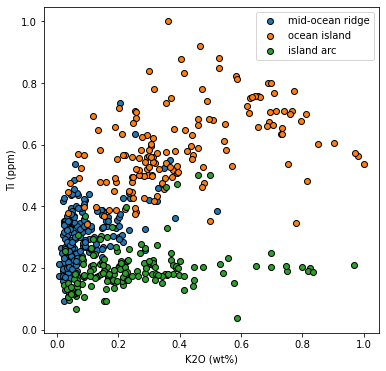

In [35]:
basalt_data_3 = basalt_data[(~basalt_data['TiO2 (wt%)'].isna()) & (~basalt_data['V (ppm)'].isna()) & (~basalt_data['K2O (wt%)'].isna())]

basalt_data_3['Ti_norm']=basalt_data_3['TiO2 (wt%)']/np.max(basalt_data_3['TiO2 (wt%)'])
basalt_data_3['V_norm']=basalt_data_3['V (ppm)']/np.max(basalt_data_3['V (ppm)'])
basalt_data_3['K_norm']=basalt_data_3['K2O (wt%)']/np.max(basalt_data_3['K2O (wt%)'])

MORB_data = basalt_data_3[basalt_data_3['affinity']=='MORB']
OIB_data = basalt_data_3[basalt_data_3['affinity']=='OIB']
IAB_data = basalt_data_3[basalt_data_3['affinity']=='IAB']

plt.figure(figsize=(6,6))
plt.scatter(MORB_data['K_norm'],MORB_data['Ti_norm'],label='mid-ocean ridge',edgecolors='black')
plt.scatter(OIB_data['K_norm'],OIB_data['Ti_norm'],label='ocean island',edgecolors='black')
plt.scatter(IAB_data['K_norm'],IAB_data['Ti_norm'],label='island arc',edgecolors='black')
plt.xlabel('K2O (wt%)')
plt.ylabel('Ti (ppm)')
plt.legend()
plt.show()

In [40]:
# Make a randomly ordered dataframe from the initial one
randomized_basalt_data = basalt_data_3.sample(frac=1) 
N=np.int64(len(basalt_data_3)/2) # half of data
# Take the first 257 data points to use for "training"
training_data = copy.deepcopy(randomized_basalt_data.iloc[0:N])
# Use the rest to apply our machine learning on
remaining_data = copy.deepcopy(randomized_basalt_data.iloc[N:])

basalt_3_training = training_data[['Ti_norm', 'V_norm','K_norm']].values
basalt_3_remaining = remaining_data[['Ti_norm', 'V_norm','K_norm']].values
basalt_affinity_training = training_data['affinity code'].tolist()

classifier_neighbors = neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance')
classifier_neighbors.fit(basalt_3_training, basalt_affinity_training)

remaining_classes = classifier_neighbors.predict(basalt_3_remaining)
remaining_data['predicted_class'] = remaining_classes

remaining_data['correct_assignment'] = remaining_data['predicted_class'].eq(remaining_data['affinity code'])

In [41]:
remaining_data['correct_assignment'].value_counts(normalize=True) * 100

True     90.944882
False     9.055118
Name: correct_assignment, dtype: float64

In [42]:
basalt_3 = basalt_data_3[['Ti_norm', 'V_norm','K_norm']].values
basalt_affinity = basalt_data_3['affinity'].tolist()
basalt_affinity_code = basalt_data_3['affinity code'].tolist()

# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(basalt_3, basalt_affinity_code,train_size=0.5)

# fit the model on one set of data
classifier_neighbors.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = classifier_neighbors.predict(X2)
accuracy_score(y2, y2_model)

0.905511811023622